## **Import Library**

In [1]:
!pip install torch
!pip install torch-geometric

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import KBinsDiscretizer

import torch
from scipy.sparse import csr_matrix
from torch_geometric.utils import dense_to_sparse
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

## **Read Data**

In [3]:
# Load the .mat file
mat = scipy.io.loadmat('qm7.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'R', 'Z', 'T', 'P'])

In [4]:
# Extract the variables
X = mat['X']  # Feature matrix
R = mat['R']  # Cartesian coordinates
Z = mat['Z']  # Atomic numbers
T = mat['T']  # Atomization energies (label)
P = mat['P']  # Other properties

## **Change Shape**

In [5]:
R_flattened = R.reshape(R.shape[0], -1)
X_flattened = X.reshape(X.shape[0], -1)

In [6]:
Z

array([[6., 1., 1., ..., 0., 0., 0.],
       [6., 6., 1., ..., 0., 0., 0.],
       [6., 6., 1., ..., 0., 0., 0.],
       ...,
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.]], dtype=float32)

In [7]:
def one_hot_encode_Z(Z):
    num_samples, num_atoms = Z.shape
    max_atom_type = int(np.max(Z)) + 1
    encoder = OneHotEncoder(categories=[range(max_atom_type)], sparse=False)
    Z_reshaped = Z.reshape(-1, 1)
    Z_encoded = encoder.fit_transform(Z_reshaped).reshape(num_samples, num_atoms * max_atom_type)
    return Z_encoded

Z_encoded = one_hot_encode_Z(Z)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
print(X_flattened.shape)
print(R_flattened.shape)
print(Z_encoded.shape)
print(P.shape)

(7165, 529)
(7165, 69)
(7165, 391)
(5, 1433)


In [9]:
P_reshape = P.reshape(7165, -1)
print(P_reshape.shape)

(7165, 1)


In [10]:
all_features = np.hstack((X_flattened, R_flattened, Z_encoded, P_reshape))
print(f"All features shape after trimming: {all_features.shape}")

All features shape after trimming: (7165, 990)


## **Convert to csv file**

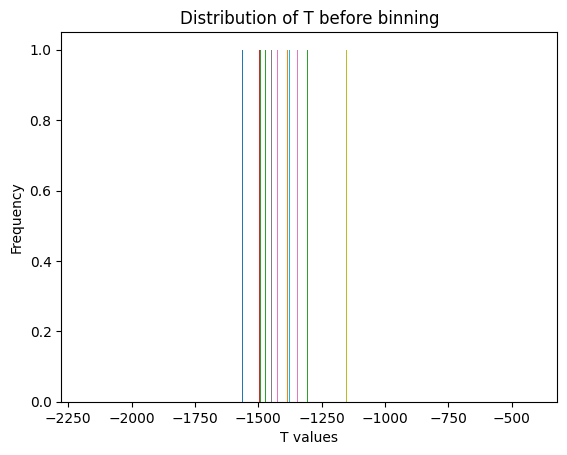

In [15]:
plt.hist(T, bins=50)
plt.title('Distribution of T before binning')
plt.xlabel('T values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('Features.csv', index=False)

In [11]:
df2=pd.read_csv('Features.csv')
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,981,982,983,984,985,986,987,988,989,Label
0,36.858105,2.907633,2.907612,2.907564,2.905349,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5578.0,-417.96
1,36.858105,12.599944,2.902000,1.473118,1.473101,2.901973,2.901886,1.473102,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2504.0,-712.42
2,36.858105,14.261827,1.503703,2.924997,2.924732,1.503680,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4851.0,-564.21
3,36.858105,15.871878,2.979434,1.401225,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3130.0,-404.88
4,73.516693,17.885317,10.561490,4.355064,2.062530,2.069614,1.581991,1.590780,1.261482,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6670.0,-808.87


In [12]:
df2.describe()

,0,1,2,3,4,5,6,7,8,9,...,981,982,983,984,985,986,987,988,989,Label
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,...,7165.0,7165.0,7165.0,7165.0,7165.0,7165.0,7165.0,7165.0,7165.000000,7165.000000
mean,78.447518,13.247392,13.651229,12.761609,11.313269,9.741235,7.374219,1.992688,1.709067,1.595967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3582.000000,-1538.037630
std,65.448339,6.134428,6.168350,5.406752,4.984658,4.785995,4.318243,0.912114,0.721890,0.698753,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2068.501672,223.934546
min,36.858105,2.907633,1.503703,1.172837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-2192.000000
25%,53.358707,9.065171,9.293125,9.019773,7.737596,6.671409,4.668823,1.421404,1.297994,1.192658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1791.000000,-1704.230000
50%,73.516693,12.434812,12.495984,10.668070,10.247300,8.685217,6.669063,1.717358,1.562530,1.470488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3582.000000,-1544.380000
75%,73.516693,15.262316,17.618086,17.504143,14.998941,10.677979,9.189721,2.049483,1.957705,1.774468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5373.000000,-1385.890000
max,388.023438,47.143398,47.179157,47.015327,29.794344,29.790239,29.617144,4.379876,4.373618,4.364484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7164.000000,-404.880000


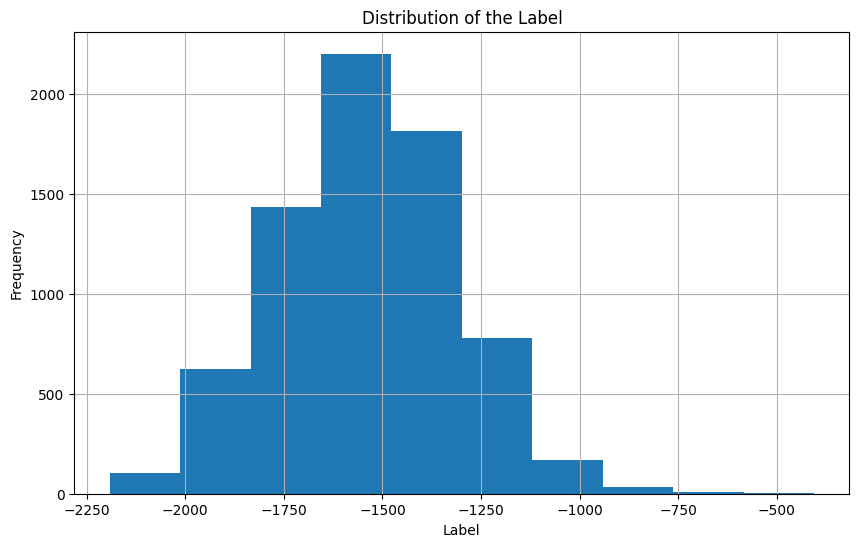

In [13]:
plt.figure(figsize=(10, 6))
df2['Label'].hist()
plt.title('Distribution of the Label')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

## **Run on Machine Learning Models**

In [14]:
# Check the shape of the concatenated data
print(df2.shape)

# Define the feature matrix X and target vector y
X = df2.iloc[:, :-1].values
y = df2.iloc[:, -1].values

# Check the distribution of y
print(np.unique(y, return_counts=True))

X=np.array(X)
y=np.array(y)

(7165, 991)
(array([-2192.  , -2191.85, -2191.74, ...,  -564.21,  -417.96,  -404.88]), array([1, 1, 1, ..., 1, 1, 1]))


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
models = {
    'KernelRidge': KernelRidge(alpha=1e-3),
    'SVR': SVR(),
    'LinearRegression': LinearRegression(),
    'XGBRegressor': xgb.XGBRegressor(n_estimators=200)
}

kf = KFold(n_splits=10, shuffle=True, random_state=1)
kernels = ['poly', 'rbf', 'sigmoid']

In [17]:
def evaluate_model(model, X, y, cv):
    # Tính toán MSE và lưu lại tất cả các điểm số
    mse_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    mse_mean = mse_scores.mean()
    mse_std = mse_scores.std()

    # Tính toán R2 và lưu lại tất cả các điểm số
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=cv)
    r2_mean = r2_scores.mean()
    r2_std = r2_scores.std()

    return mse_mean, mse_std, r2_mean, r2_std

In [18]:
results = {}

for model_name, model in models.items():
    if model_name in ['KernelRidge', 'SVR']:
        for kernel in kernels:
            model.set_params(kernel=kernel)

            # Cross-validation scores
            mse_cv, mse_std, r2_cv, r2_std = evaluate_model(model, X_train, y_train, kf)

            # Train the model
            model.fit(X_train, y_train)

            # Predict on the test set
            y_pred = model.predict(X_test)

            # Calculate metrics
            mse_test = mean_squared_error(y_test, y_pred)
            r2_test = r2_score(y_test, y_pred)

            # Store results
            results[f"{model_name}_{kernel}"] = {
                'MSE (CV)': mse_cv,
                'MSE Std (CV)': mse_std,
                'R2 Score (CV)': r2_cv,
                'R2 Std (CV)': r2_std,
                'MSE (Test)': mse_test,
                'R2 Score (Test)': r2_test
            }
    else:
        # Cross-validation scores
        mse_cv, mse_std, r2_cv, r2_std = evaluate_model(model, X_train, y_train, kf)

        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse_test = mean_squared_error(y_test, y_pred)
        r2_test = r2_score(y_test, y_pred)

        # Store results
        results[model_name] = {
            'MSE (CV)': mse_cv,
            'MSE Std (CV)': mse_std,
            'R2 Score (CV)': r2_cv,
            'R2 Std (CV)': r2_std,
            'MSE (Test)': mse_test,
            'R2 Score (Test)': r2_test
        }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=9.38174e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=1.74014e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=9.44152e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=9.54641e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:237: 

                         MSE (CV)  MSE Std (CV)  R2 Score (CV)   R2 Std (CV)  \
KernelRidge_poly     2.855964e+04  1.884581e+04   4.065057e-01  4.403843e-01   
KernelRidge_rbf      4.246292e+05  2.489542e+04  -7.527440e+00  3.680041e-01   
KernelRidge_sigmoid  5.000993e+04  3.426761e+03  -2.686898e-03  3.967614e-03   
SVR_poly             4.988002e+04  3.401032e+03  -9.245291e-05  3.021174e-03   
SVR_rbf              4.996648e+04  3.388323e+03  -1.855336e-03  2.954795e-03   
SVR_sigmoid          5.000534e+04  3.363868e+03  -2.682985e-03  3.509209e-03   
LinearRegression     3.323062e+16  9.133213e+16  -6.463397e+11  1.765149e+12   
XGBRegressor         2.129528e+02  3.908760e+01   9.957225e-01  7.761498e-04   

                       MSE (Test)  R2 Score (Test)  
KernelRidge_poly     1.789371e+04     6.481075e-01  
KernelRidge_rbf      3.942758e+05    -6.753714e+00  
KernelRidge_sigmoid  5.095103e+04    -1.988278e-03  
SVR_poly             5.074120e+04     2.138204e-03  
SVR_rbf       

## **Visualize Result**

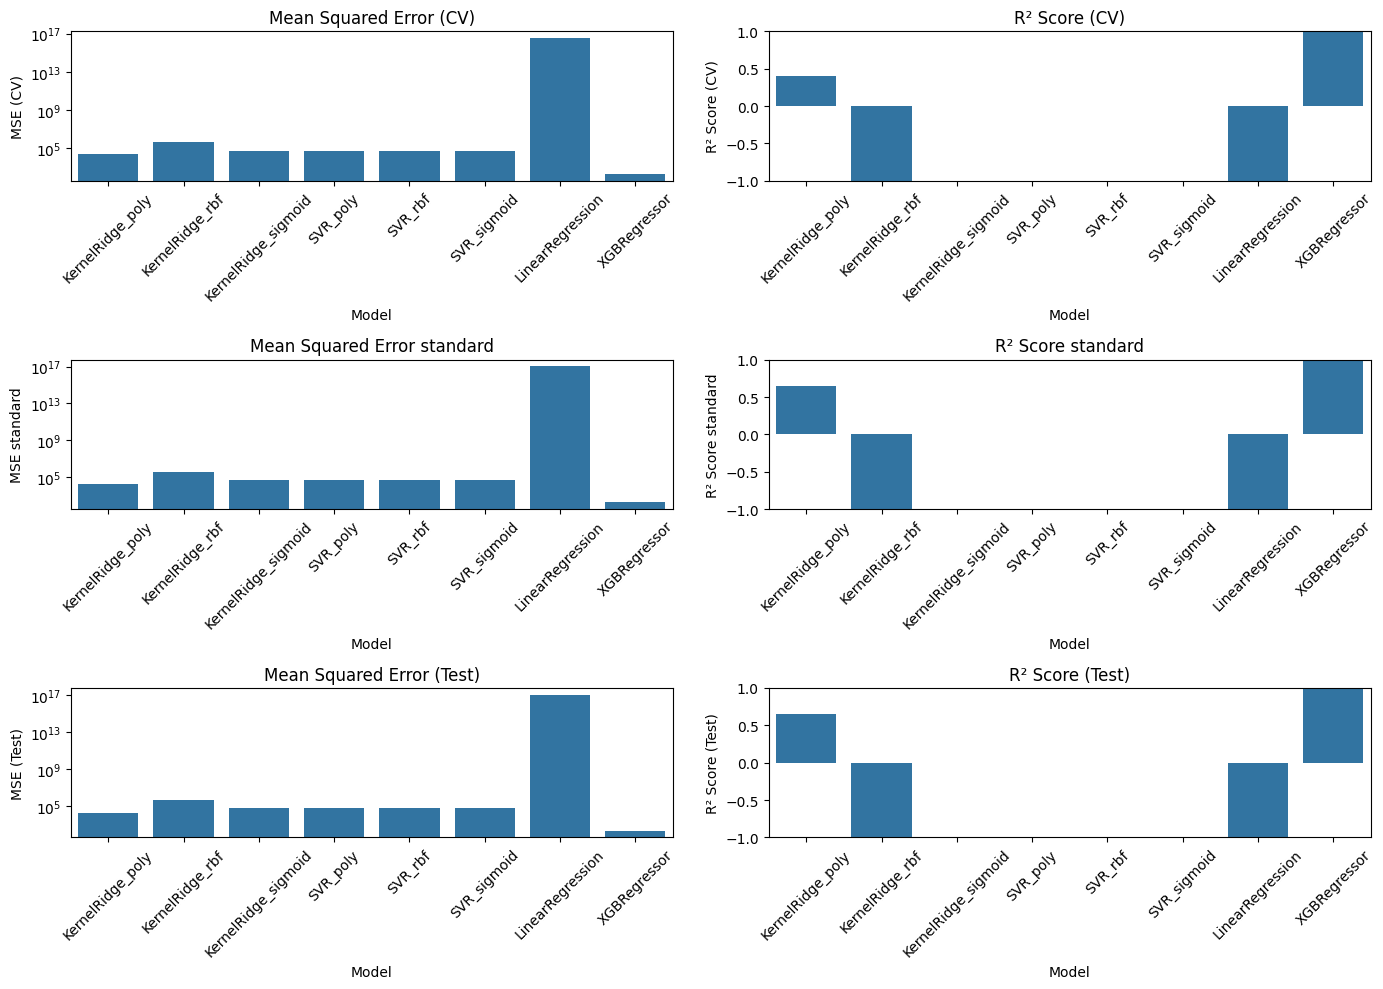

In [27]:
plt.figure(figsize=(14, 10))

# MSE (CV)
plt.subplot(3, 2, 1)
sns.barplot(x=results_df.index, y=results_df['MSE (CV)'])
plt.title('Mean Squared Error (CV)')
plt.xlabel('Model')
plt.ylabel('MSE (CV)')
plt.yscale('log')
plt.xticks(rotation=45)

# R² Score (CV)
plt.subplot(3, 2, 2)
sns.barplot(x=results_df.index, y=results_df['R2 Score (CV)'])
plt.title('R² Score (CV)')
plt.xlabel('Model')
plt.ylabel('R² Score (CV)')
plt.ylim(-1, 1)
plt.xticks(rotation=45)

# MSE std
plt.subplot(3, 2, 3)
sns.barplot(x=results_df.index, y=results_df['MSE (Test)'])
plt.title('Mean Squared Error standard')
plt.xlabel('Model')
plt.ylabel('MSE standard')
plt.yscale('log')
plt.xticks(rotation=45)

# R² std
plt.subplot(3, 2, 4)
sns.barplot(x=results_df.index, y=results_df['R2 Score (Test)'])
plt.title('R² Score standard')
plt.xlabel('Model')
plt.ylabel('R² Score standard')
plt.ylim(-1, 1)
plt.xticks(rotation=45)

# MSE (Test)
plt.subplot(3, 2, 5)
sns.barplot(x=results_df.index, y=results_df['MSE (Test)'])
plt.title('Mean Squared Error (Test)')
plt.xlabel('Model')
plt.ylabel('MSE (Test)')
plt.yscale('log')
plt.xticks(rotation=45)

# R² Score (Test)
plt.subplot(3, 2, 6)
sns.barplot(x=results_df.index, y=results_df['R2 Score (Test)'])
plt.title('R² Score (Test)')
plt.xlabel('Model')
plt.ylabel('R² Score (Test)')
plt.ylim(-1, 1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## **GNN**

In [28]:
# Convert train and test data into sparse matrix
sparse_matrix_train = csr_matrix(X_train)
sparse_matrix_test = csr_matrix(X_test)

# Convert sparse matrix into dense matrix
node_features_train = torch.tensor(sparse_matrix_train.toarray(), dtype=torch.float)
node_features_test = torch.tensor(sparse_matrix_test.toarray(), dtype=torch.float)

# Convert dense matrix into sparse representation
edge_index_train, edge_attr_train = dense_to_sparse(node_features_train)
edge_index_test, edge_attr_test = dense_to_sparse(node_features_test)

# Convert labels into tensor
labels_train = torch.tensor(y_train, dtype=torch.float)
labels_test = torch.tensor(y_test, dtype=torch.float)

print(f"Train Edge Index:\n{edge_index_train}")
print(f"Train Node Features Shape: {node_features_train.shape}")
print(f"Train Labels Shape: {labels_train.shape}")


Train Edge Index:
tensor([[   0,    0,    0,  ..., 5731, 5731, 5731],
        [   0,    1,    2,  ...,  955,  972,  989]])
Train Node Features Shape: torch.Size([5732, 990])
Train Labels Shape: torch.Size([5732])


In [29]:
class GCNRegression(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNRegression, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, node_features, edge_index):
        x = self.conv1(node_features, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [30]:
model = GCNRegression(input_dim=node_features_train.shape[1], hidden_dim=64, output_dim=1)

# Use Adam optimizer and Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [31]:
# List to store loss values
train_losses = []

# Training loop with loss storage
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(node_features_train, edge_index_train).squeeze()
    loss = criterion(out, labels_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 4562712.0
Epoch 5, Loss: 5468117.0
Epoch 10, Loss: 3582781.25
Epoch 15, Loss: 3096413.0
Epoch 20, Loss: 2744736.0
Epoch 25, Loss: 2443654.5
Epoch 30, Loss: 2252135.5
Epoch 35, Loss: 2162911.0
Epoch 40, Loss: 2133029.5
Epoch 45, Loss: 2125043.25
Epoch 50, Loss: 2122809.0
Epoch 55, Loss: 2121201.0
Epoch 60, Loss: 2119464.5
Epoch 65, Loss: 2117790.5
Epoch 70, Loss: 2116322.0
Epoch 75, Loss: 2115062.75
Epoch 80, Loss: 2113924.75
Epoch 85, Loss: 2112798.75
Epoch 90, Loss: 2111627.75
Epoch 95, Loss: 2110426.5


In [32]:
# After training, evaluate and visualize the predictions
model.eval()
with torch.no_grad():
    output_test = model(node_features_test, edge_index_test).squeeze()
    mse_test = criterion(output_test, labels_test).item()
    print(f'Test Mean Squared Error: {mse_test}')

    # Convert tensors to numpy for plotting
    output_test_np = output_test.cpu().numpy()
    labels_test_np = labels_test.cpu().numpy()


Test Mean Squared Error: 1697099.625


## **Visualize Result**

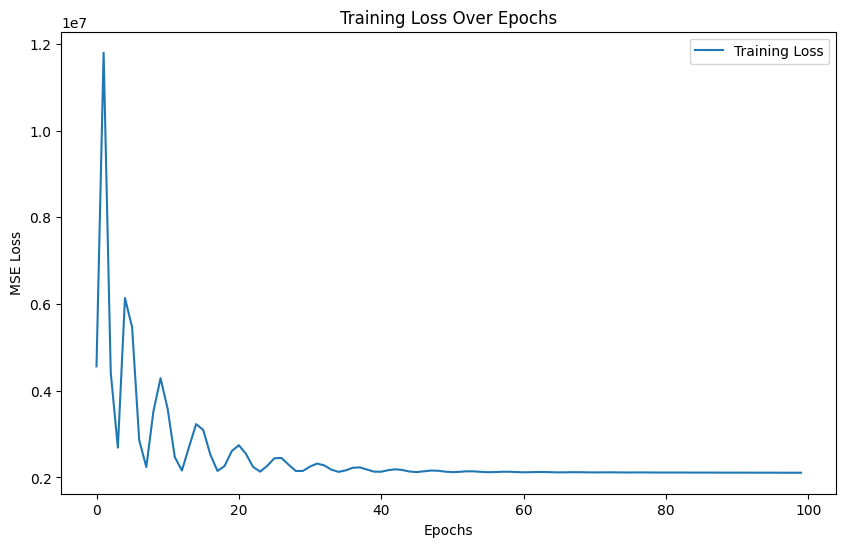

In [33]:
# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

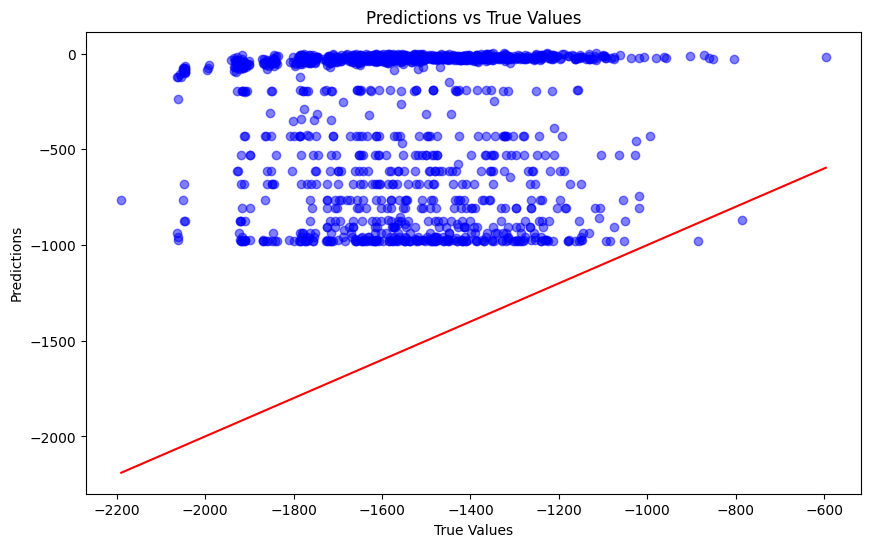

In [34]:
# Plot predictions vs true values
plt.figure(figsize=(10, 6))
plt.scatter(labels_test_np, output_test_np, color='blue', alpha=0.5)
plt.plot([min(labels_test_np), max(labels_test_np)], [min(labels_test_np), max(labels_test_np)], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.show()

## **Features Extraction**

In [35]:
all_features = np.hstack((X_flattened, R_flattened, P_reshape))
print(f"All features shape after trimming: {all_features.shape}")

All features shape after trimming: (7165, 599)


In [38]:
# Check the shape of the concatenated data
print(all_features.shape)

# Define the feature matrix X and target vector y
X = all_features[:, :-1]
y = all_features[:, -1]

# Check the distribution of y
print(np.unique(y, return_counts=True))

X=np.array(X)
y=np.array(y)

(7165, 599)
(array([0.000e+00, 1.000e+00, 2.000e+00, ..., 7.162e+03, 7.163e+03,
       7.164e+03]), array([1, 1, 1, ..., 1, 1, 1]))


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
models = {
    'KernelRidge': KernelRidge(alpha=1e-3),
    'SVR': SVR(),
    'LinearRegression': LinearRegression(),
    'XGBRegressor': xgb.XGBRegressor(n_estimators=200)
}

kf = KFold(n_splits=10, shuffle=True, random_state=1)
kernels = ['poly', 'rbf', 'sigmoid']

In [41]:
def evaluate_model(model, X, y, cv):
    # Tính toán MSE và lưu lại tất cả các điểm số
    mse_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    mse_mean = mse_scores.mean()
    mse_std = mse_scores.std()

    # Tính toán R2 và lưu lại tất cả các điểm số
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=cv)
    r2_mean = r2_scores.mean()
    r2_std = r2_scores.std()

    return mse_mean, mse_std, r2_mean, r2_std

In [42]:
results = {}

for model_name, model in models.items():
    if model_name in ['KernelRidge', 'SVR']:
        for kernel in kernels:
            model.set_params(kernel=kernel)

            # Cross-validation scores
            mse_cv, mse_std, r2_cv, r2_std = evaluate_model(model, X_train, y_train, kf)

            # Train the model
            model.fit(X_train, y_train)

            # Predict on the test set
            y_pred = model.predict(X_test)

            # Calculate metrics
            mse_test = mean_squared_error(y_test, y_pred)
            r2_test = r2_score(y_test, y_pred)

            # Store results
            results[f"{model_name}_{kernel}"] = {
                'MSE (CV)': mse_cv,
                'MSE Std (CV)': mse_std,
                'R2 Score (CV)': r2_cv,
                'R2 Std (CV)': r2_std,
                'MSE (Test)': mse_test,
                'R2 Score (Test)': r2_test
            }
    else:
        # Cross-validation scores
        mse_cv, mse_std, r2_cv, r2_std = evaluate_model(model, X_train, y_train, kf)

        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse_test = mean_squared_error(y_test, y_pred)
        r2_test = r2_score(y_test, y_pred)

        # Store results
        results[model_name] = {
            'MSE (CV)': mse_cv,
            'MSE Std (CV)': mse_std,
            'R2 Score (CV)': r2_cv,
            'R2 Std (CV)': r2_std,
            'MSE (Test)': mse_test,
            'R2 Score (Test)': r2_test
        }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:239:

                         MSE (CV)  MSE Std (CV)  R2 Score (CV)  R2 Std (CV)  \
KernelRidge_poly     2.058873e+07  4.262519e+06      -3.856747     1.001932   
KernelRidge_rbf      5.341503e+06  2.450530e+05      -0.259211     0.047398   
KernelRidge_sigmoid  4.817034e+06  1.696370e+06      -0.135385     0.400261   
SVR_poly             4.255618e+06  1.982779e+05      -0.002514     0.002950   
SVR_rbf              4.254027e+06  1.985850e+05      -0.002134     0.002776   
SVR_sigmoid          4.253990e+06  1.987521e+05      -0.002124     0.002821   
LinearRegression     5.063501e+07  1.252421e+08     -10.937504    29.540165   
XGBRegressor         5.218638e+06  2.349284e+05      -0.230309     0.045336   

                       MSE (Test)  R2 Score (Test)  
KernelRidge_poly     2.214123e+07        -4.048684  
KernelRidge_rbf      5.454509e+06        -0.243747  
KernelRidge_sigmoid  4.382663e+06         0.000657  
SVR_poly             4.383017e+06         0.000576  
SVR_rbf              4.

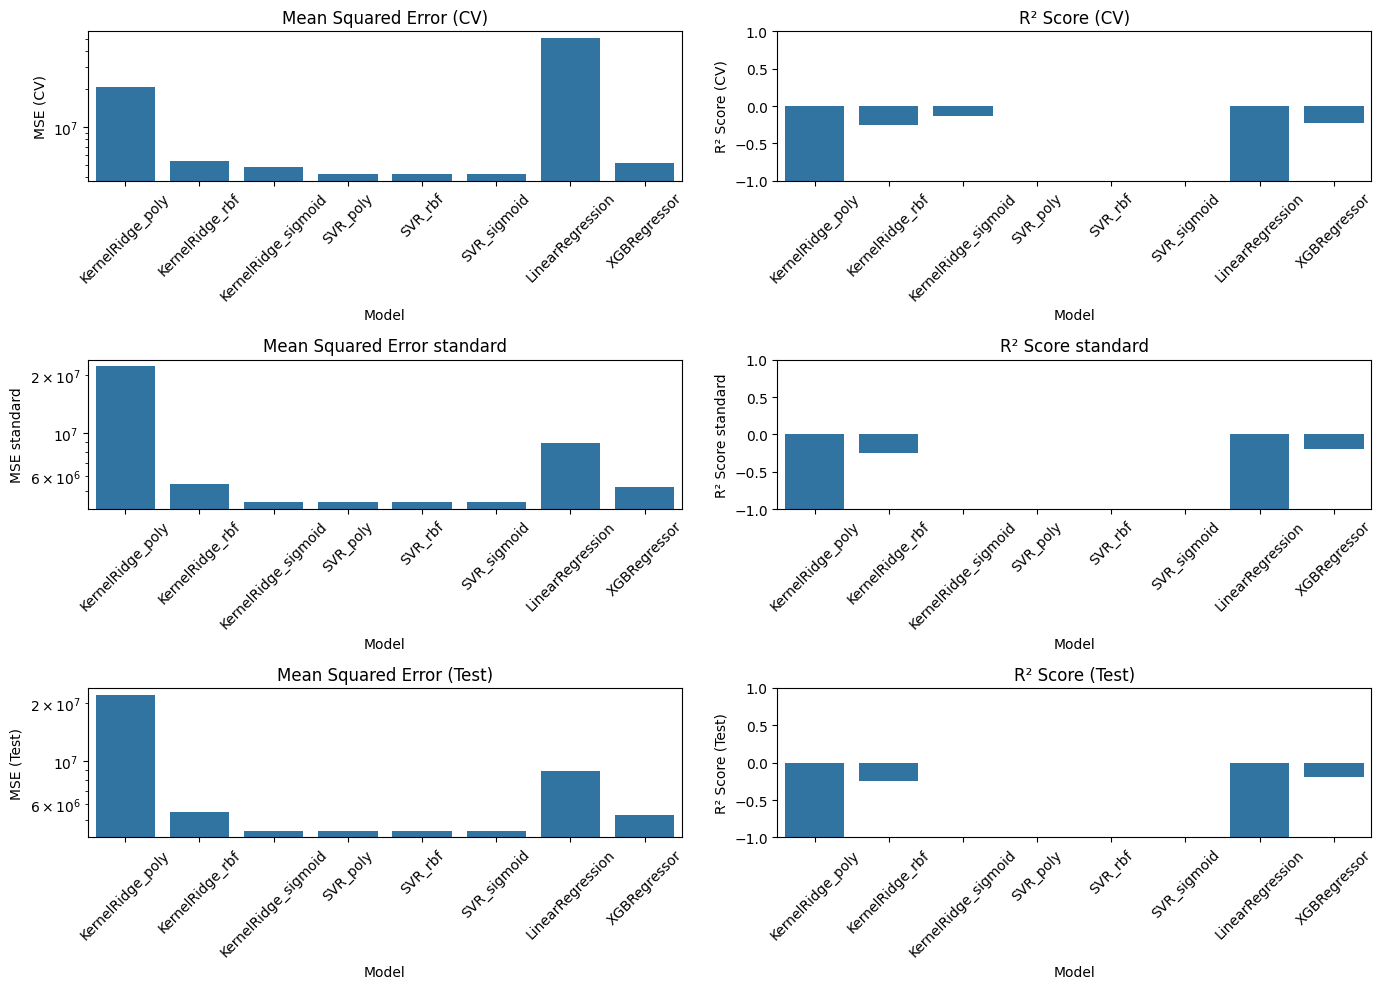

In [43]:
plt.figure(figsize=(14, 10))

# MSE (CV)
plt.subplot(3, 2, 1)
sns.barplot(x=results_df.index, y=results_df['MSE (CV)'])
plt.title('Mean Squared Error (CV)')
plt.xlabel('Model')
plt.ylabel('MSE (CV)')
plt.yscale('log')
plt.xticks(rotation=45)

# R² Score (CV)
plt.subplot(3, 2, 2)
sns.barplot(x=results_df.index, y=results_df['R2 Score (CV)'])
plt.title('R² Score (CV)')
plt.xlabel('Model')
plt.ylabel('R² Score (CV)')
plt.ylim(-1, 1)
plt.xticks(rotation=45)

# MSE std
plt.subplot(3, 2, 3)
sns.barplot(x=results_df.index, y=results_df['MSE (Test)'])
plt.title('Mean Squared Error standard')
plt.xlabel('Model')
plt.ylabel('MSE standard')
plt.yscale('log')
plt.xticks(rotation=45)

# R² std
plt.subplot(3, 2, 4)
sns.barplot(x=results_df.index, y=results_df['R2 Score (Test)'])
plt.title('R² Score standard')
plt.xlabel('Model')
plt.ylabel('R² Score standard')
plt.ylim(-1, 1)
plt.xticks(rotation=45)

# MSE (Test)
plt.subplot(3, 2, 5)
sns.barplot(x=results_df.index, y=results_df['MSE (Test)'])
plt.title('Mean Squared Error (Test)')
plt.xlabel('Model')
plt.ylabel('MSE (Test)')
plt.yscale('log')
plt.xticks(rotation=45)

# R² Score (Test)
plt.subplot(3, 2, 6)
sns.barplot(x=results_df.index, y=results_df['R2 Score (Test)'])
plt.title('R² Score (Test)')
plt.xlabel('Model')
plt.ylabel('R² Score (Test)')
plt.ylim(-1, 1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## **GNN For Features Extraction**

In [44]:
# Convert train and test data into sparse matrix
sparse_matrix_train = csr_matrix(X_train)
sparse_matrix_test = csr_matrix(X_test)

# Convert sparse matrix into dense matrix
node_features_train = torch.tensor(sparse_matrix_train.toarray(), dtype=torch.float)
node_features_test = torch.tensor(sparse_matrix_test.toarray(), dtype=torch.float)

# Convert dense matrix into sparse representation
edge_index_train, edge_attr_train = dense_to_sparse(node_features_train)
edge_index_test, edge_attr_test = dense_to_sparse(node_features_test)

# Convert labels into tensor
labels_train = torch.tensor(y_train, dtype=torch.float)
labels_test = torch.tensor(y_test, dtype=torch.float)

print(f"Train Edge Index:\n{edge_index_train}")
print(f"Train Node Features Shape: {node_features_train.shape}")
print(f"Train Labels Shape: {labels_train.shape}")


Train Edge Index:
tensor([[   0,    0,    0,  ..., 5731, 5731, 5731],
        [   0,    1,    2,  ...,  568,  569,  570]])
Train Node Features Shape: torch.Size([5732, 598])
Train Labels Shape: torch.Size([5732])


In [45]:
class GCNRegression(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNRegression, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, node_features, edge_index):
        x = self.conv1(node_features, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [46]:
model = GCNRegression(input_dim=node_features_train.shape[1], hidden_dim=64, output_dim=1)

# Use Adam optimizer and Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [47]:
# List to store loss values
train_losses = []

# Training loop with loss storage
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(node_features_train, edge_index_train).squeeze()
    loss = criterion(out, labels_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 16677674.0
Epoch 5, Loss: 15684064.0
Epoch 10, Loss: 15664284.0
Epoch 15, Loss: 15667583.0
Epoch 20, Loss: 15643379.0
Epoch 25, Loss: 15607472.0
Epoch 30, Loss: 15588737.0
Epoch 35, Loss: 15577462.0
Epoch 40, Loss: 15564567.0
Epoch 45, Loss: 15551147.0
Epoch 50, Loss: 15539169.0
Epoch 55, Loss: 15528964.0
Epoch 60, Loss: 15520058.0
Epoch 65, Loss: 15511996.0
Epoch 70, Loss: 15504469.0
Epoch 75, Loss: 15497388.0
Epoch 80, Loss: 15490698.0
Epoch 85, Loss: 15484376.0
Epoch 90, Loss: 15478455.0
Epoch 95, Loss: 15472950.0


In [48]:
# After training, evaluate and visualize the predictions
model.eval()
with torch.no_grad():
    output_test = model(node_features_test, edge_index_test).squeeze()
    mse_test = criterion(output_test, labels_test).item()
    print(f'Test Mean Squared Error: {mse_test}')

    # Convert tensors to numpy for plotting
    output_test_np = output_test.cpu().numpy()
    labels_test_np = labels_test.cpu().numpy()


Test Mean Squared Error: 13136575.0


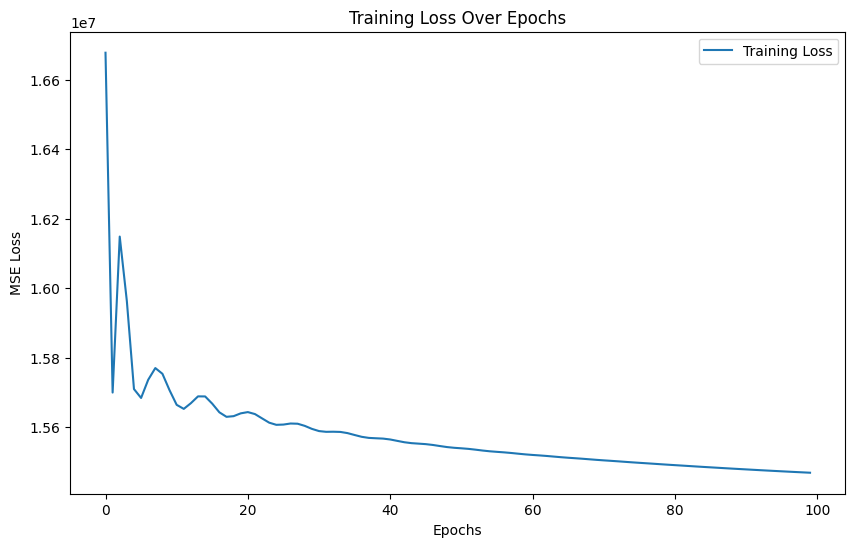

In [49]:
# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()